## Imports and Data Loading

We import necessary modules/functons and scaled data using only index data. We then implement our CNN-LSTM architecture with the filter configuration: [16, 32, 64].

In [37]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.regularizers import l2

# load data
scaled_data = pd.read_csv(os.path.join('..', 'data', 'processed', 'scaled_data.csv'), index_col= ['Date'], usecols=['Date', '_MKT'])

display(scaled_data)

def create_lagged_dataset(data, lag):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data.iloc[i:(i + lag)].values)
        y.append(data.iloc[i + lag]['_MKT'])
    return np.array(X), np.array(y)

# lagged dataset
lag = 4 # use prev 4 week data to predict (approx. 1 month)
X, y = create_lagged_dataset(scaled_data, lag=lag)

# time-based split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')

# input shape
input_shape = (X.shape[1], X.shape[2])

,_MKT
Date,
1988-04-10,0.001175
1988-04-17,0.000463
1988-04-24,0.000465
1988-05-01,0.000606
1988-05-08,0.000296
...,...
2024-04-07,0.990466
2024-04-14,0.974132
2024-04-21,0.943699


Training data shape: (1503, 4, 1)
Testing data shape: (376, 4, 1)


In [26]:
# build
inputs = Input(shape=input_shape)
x = Conv1D(filters=16, kernel_size=2, activation='relu')(inputs)
x = Conv1D(filters=32, kernel_size=2, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=2, activation='relu')(x)
x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Reshape((8, 1))(x)
x = LSTM(50, return_sequences=True)(x)
x = LSTM(50)(x)
outputs = Dense(1)(x)

# compile
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# output summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 16)          │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2, 32)          │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,659 (151.01 KB)

 Trainable params: 38,659 (151.01 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# train
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), verbose=0)

## Evaluating the Base Model

We can see that the base model performs comparably to our model including macroeconomic indicators in-sample, but performs slightly better out-of-sample.

In [28]:
# predict
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# evaluate model
is_mse = mean_squared_error(y_train, train_predictions)
is_rmse = np.sqrt(is_mse)
is_mae = mean_absolute_error(y_train, train_predictions)
is_mape = mean_absolute_percentage_error(y_train, train_predictions)
is_r2 = r2_score(y_train, train_predictions)
os_mse = mean_squared_error(y_test, test_predictions)
os_rmse = np.sqrt(os_mse)
os_mae = mean_absolute_error(y_test, test_predictions)
os_mape = mean_absolute_percentage_error(y_test, test_predictions)
os_r2 = r2_score(y_test, test_predictions)

print(f'In-Sample MSE: {is_mse}')
print(f'Out-of-Sample MSE: {os_mse}')
print(f'In-Sample RMSE: {is_rmse}')
print(f'Out-of-Sample RMSE: {os_rmse}')
print(f'In-Sample MAE: {is_mae}')
print(f'Out-of-Sample MAE: {os_mae}')
print(f'In-Sample MAPE: {is_mape}')
print(f'Out-of-Sample MAPE: {os_mape}')
print(f'In-Sample R2: {is_r2}')
print(f'Out-of-Sample R2: {os_r2}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
In-Sample MSE: 3.6324587172715926e-05
Out-of-Sample MSE: 0.000823150594384096
In-Sample RMSE: 0.006026988233995146
Out-of-Sample RMSE: 0.02869060115062241
In-Sample MAE: 0.00495205215410053
Out-of-Sample MAE: 0.022094546354782075
In-Sample MAPE: 912728549.2104021
Out-of-Sample MAPE: 0.03245574997882432
In-Sample R2: 0.9962742599813412
Out-of-Sample R2: 0.9703201067572682


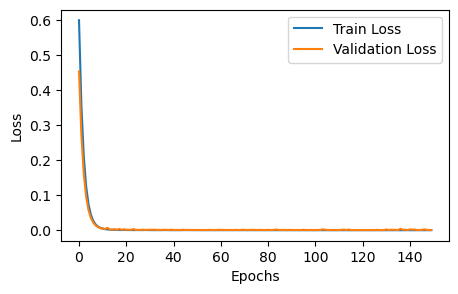

In [29]:
# training & validation loss values as fxn of epochs
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

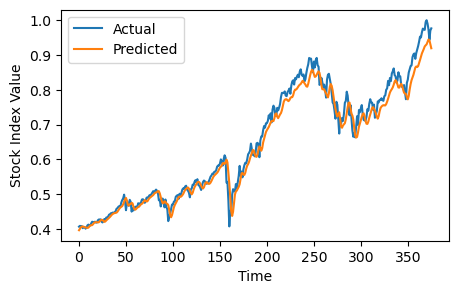

In [30]:
# actual vs predicted values
plt.figure(figsize=(5, 3))
plt.plot(y_test, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Index Value')
plt.legend()
plt.show()

In [21]:
from sklearn.model_selection import TimeSeriesSplit

# k-fold
tscv = TimeSeriesSplit(n_splits=5)
cross_val_results = []

for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # train
    model.fit(X_train_cv, y_train_cv, epochs=150, validation_data=(X_test_cv, y_test_cv), verbose=0)

    # predict
    test_predictions_cv = model.predict(X_test_cv)
    
    # evaluate
    mse_cv = mean_squared_error(y_test_cv, test_predictions_cv)
    rmse_cv = np.sqrt(mse_cv)
    mae_cv = mean_absolute_error(y_test_cv, test_predictions_cv)
    mape_cv = mean_absolute_percentage_error(y_test_cv, test_predictions_cv)
    r2_cv = r2_score(y_test_cv, test_predictions_cv)
    
    cross_val_results.append((mse_cv, rmse_cv, mae_cv, mape_cv, r2_cv))

# avg metrics
avg_cross_val_results = np.mean(cross_val_results, axis=0)
print(f'Cross-Validation MSE: {avg_cross_val_results[0]}')
print(f'Cross-Validation RMSE: {avg_cross_val_results[1]}')
print(f'Cross-Validation MAE: {avg_cross_val_results[2]}')
print(f'Cross-Validation MAPE: {avg_cross_val_results[3]}')
print(f'Cross-Validation R2: {avg_cross_val_results[4]}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Cross-Validation MSE: 0.0017187205514004856
Cross-Validation RMSE: 0.026351871815187833
Cross-Validation MAE: 0.02106902584597016
Cross-Validation MAPE: 0.05499812835177407
Cross-Validation R2: 0.878151079952006


## Testing the Model

We implement a simple trading strategy that buys the underlying, provided a positive outlook, and sells the underlying otherwise, benchmarking it with a buy and hold strategy of the underlying so as to compare our results with the macroeconomic model.

In [39]:
# load raw market data
data = pd.read_excel(os.path.join('..', 'data', 'raw', 'market_data.xlsx'), usecols=['Date', 'PE', 'CPI', 'M2', '_MKT'])
data.set_index(['Date'], inplace=True)

# generate buy/sell signals
def generate_signals(predictions):
    signals = np.zeros_like(predictions)
    signals[1:] = np.where(predictions[1:] > predictions[:-1], 1, -1)  # buy if next prediction is higher, sell if lower
    return signals

train_signals = generate_signals(train_predictions.flatten())
test_signals = generate_signals(test_predictions.flatten())

train_signals = train_signals[1:]
test_signals = test_signals[1:]

# returns
def calculate_pnl1(signals, returns):
    return signals * returns  # PnL
# check robustness to implementation delay
def calculate_pnl2(signals, returns):
    return signals[1:] * returns[:-1]
# market returns
market_returns_train = data['_MKT'].iloc[:train_size].pct_change().dropna().values
market_returns_test = data['_MKT'].iloc[train_size+lag:].pct_change().dropna().values

train_pnl1 = calculate_pnl1(train_signals, market_returns_train)
train_pnl2 = calculate_pnl2(train_signals, market_returns_train)
test_pnl1 = calculate_pnl1(test_signals, market_returns_test)
test_pnl2 = calculate_pnl2(test_signals, market_returns_test)

# cumulative returns
train_cumulative_pnl1 = np.cumsum(train_pnl1)
test_cumulative_pnl1 = np.cumsum(test_pnl1)
train_cumulative_pnl2 = np.cumsum(train_pnl2)
test_cumulative_pnl2 = np.cumsum(test_pnl2)

# IR
def calculate_ir(pnl, market_returns):
    excess_returns = pnl - market_returns
    return (np.mean(excess_returns) / np.std(excess_returns)) * np.sqrt(52)  # Annualized IR

train_ir1 = calculate_ir(train_pnl1, market_returns_train)
test_ir1 = calculate_ir(test_pnl1, market_returns_test)
train_ir2 = calculate_ir(train_pnl2, market_returns_train[:-1])
test_ir2 = calculate_ir(test_pnl2, market_returns_test[:-1])

print(f'In-Sample IR for [t+1]: {train_ir1}')
print(f'Out-of-Sample IR for [t+1]: {test_ir1}')
print(f'In-Sample IR for [t+2]: {train_ir2}')
print(f'Out-of-Sample IR for [t+2]: {test_ir2}')

# underlying strategy returns
def calculate_buy_and_hold_returns(data, train_size, lag):
    bh_returns_train = data['_MKT'].iloc[:train_size].pct_change().dropna().values
    bh_returns_test = data['_MKT'].iloc[train_size+lag:].pct_change().dropna().values
    
    bh_cumulative_returns_train = np.cumsum(bh_returns_train)
    bh_cumulative_returns_test = np.cumsum(bh_returns_test)
    
    return bh_cumulative_returns_train, bh_cumulative_returns_test

bh_cumulative_returns_train, bh_cumulative_returns_test = calculate_buy_and_hold_returns(data, train_size, lag)


In-Sample IR for [t+1]: 0.400664164007755
Out-of-Sample IR for [t+1]: -0.47692249742677656
In-Sample IR for [t+2]: -0.42324943832470213
Out-of-Sample IR for [t+2]: 0.5686205163272247


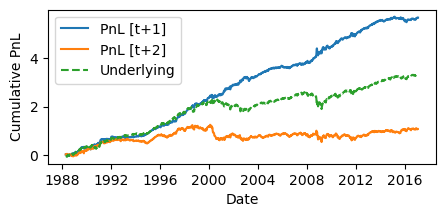

In [40]:
# plot
plt.figure(figsize=(5, 2))
plt.plot(data.index[:train_size][1:len(train_cumulative_pnl1)+1], train_cumulative_pnl1, label='PnL [t+1]')
plt.plot(data.index[:train_size][1:len(train_cumulative_pnl2)+1], train_cumulative_pnl2, label='PnL [t+2]')
plt.plot(data.index[:train_size][1:len(bh_cumulative_returns_train)+1], bh_cumulative_returns_train, label='Underlying', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()

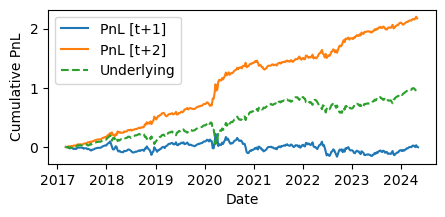

In [41]:
# plot
plt.figure(figsize=(5, 2))
plt.plot(data.index[train_size+lag:][1:len(test_cumulative_pnl1)+1], test_cumulative_pnl1, label='PnL [t+1]')
plt.plot(data.index[train_size+lag:][1:len(test_cumulative_pnl2)+1], test_cumulative_pnl2, label='PnL [t+2]')
plt.plot(data.index[train_size+lag:][1:len(bh_cumulative_returns_test)+1], bh_cumulative_returns_test, label='Underlying', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()